## MLP for Singapore Airlines Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

### Data Loading

In [26]:
# Load features
X_train = load_npz("sia_preproc_70_10_20/X_train_tfidf.npz")
X_val   = load_npz("sia_preproc_70_10_20/X_val_tfidf.npz")
X_test  = load_npz("sia_preproc_70_10_20/X_test_tfidf.npz")

# Load labels
y_train = pd.read_csv("sia_preproc_70_10_20/train_split.csv")["label"].values
y_val   = pd.read_csv("sia_preproc_70_10_20/val_split.csv")["label"].values
y_test  = pd.read_csv("sia_preproc_70_10_20/test_split.csv")["label"].values

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (7000, 42199) (7000,)
Validation set shape: (1000, 42199) (1000,)
Test set shape: (2000, 42199) (2000,)


In [27]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
label_names = list(le.classes_)

Adjust Class Weights to address imbalance

In [28]:
class_counts = np.bincount(y_train, minlength=3)
class_weights = (class_counts.sum() / (len(class_counts) * np.maximum(class_counts, 1))).astype("float32")
class_weights = torch.tensor(class_weights)

In [29]:
class SparseCSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze(0).astype("float32")
        y = np.int64(self.y[idx])
        return x, y
    
train_loader = DataLoader(SparseCSRDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(SparseCSRDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(SparseCSRDataset(X_test, y_test), batch_size=128, shuffle=False)

### Define MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim=3, hidden=(512, 256), p=0.3):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1, bias=True)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2, bias=True)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop = nn.Dropout(p)
        self.fc3 = nn.Linear(h2, out_dim, bias=True)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.fc3(x)
        return x

in_dim = X_train.shape[1]
model = MLP(in_dim=in_dim, out_dim=3, hidden=(512, 256), p=0.3)

for param_tensor in model.state_dict():
  print(param_tensor, ":", model.state_dict()[param_tensor].size())

fc1.weight : torch.Size([512, 42199])
fc1.bias : torch.Size([512])
bn1.weight : torch.Size([512])
bn1.bias : torch.Size([512])
bn1.running_mean : torch.Size([512])
bn1.running_var : torch.Size([512])
bn1.num_batches_tracked : torch.Size([])
fc2.weight : torch.Size([256, 512])
fc2.bias : torch.Size([256])
bn2.weight : torch.Size([256])
bn2.bias : torch.Size([256])
bn2.running_mean : torch.Size([256])
bn2.running_var : torch.Size([256])
bn2.num_batches_tracked : torch.Size([])
fc3.weight : torch.Size([3, 256])
fc3.bias : torch.Size([3])


### Model Training and Validation

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0)

In [ ]:
train_losses, val_losses = [], []
val_acc_hist, val_f1_hist = [], []

EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    train_loss = 0.0

    for data, target in train_loader:
        data = data.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / max(len(train_loader), 1)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_y, all_p = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).long()

            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

            all_y.append(target.cpu().numpy())
            all_p.append(pred.cpu().numpy())

    avg_val_loss = val_loss / max(len(val_loader), 1)
    val_losses.append(avg_val_loss)

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    val_acc = 100.0 * correct / max(total, 1)
    val_macro_f1 = f1_score(y_true, y_pred, average="macro")
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_macro_f1)

    print(f"Epoch {epoch:2d} | "
          f"TrainLoss {avg_train_loss:.4f} | "
          f"ValLoss {avg_val_loss:.4f} | "
          f"ValAcc {val_acc:.2f}% | "
          f"ValMacroF1 {val_macro_f1:.4f}")

Epoch  1 | TrainLoss 0.7748 | ValLoss 1.0347 | ValAcc 34.10% | ValMacroF1 0.2414
Epoch  2 | TrainLoss 0.2657 | ValLoss 0.6123 | ValAcc 80.00% | ValMacroF1 0.6929
Epoch  3 | TrainLoss 0.0810 | ValLoss 0.6543 | ValAcc 81.40% | ValMacroF1 0.6898
Epoch  4 | TrainLoss 0.0282 | ValLoss 0.6696 | ValAcc 82.20% | ValMacroF1 0.7025
Epoch  5 | TrainLoss 0.0118 | ValLoss 0.6983 | ValAcc 83.20% | ValMacroF1 0.7124
Epoch  6 | TrainLoss 0.0064 | ValLoss 0.7209 | ValAcc 82.70% | ValMacroF1 0.7063
Epoch  7 | TrainLoss 0.0037 | ValLoss 0.7427 | ValAcc 82.50% | ValMacroF1 0.6986
Epoch  8 | TrainLoss 0.0025 | ValLoss 0.7625 | ValAcc 82.80% | ValMacroF1 0.7096
Epoch  9 | TrainLoss 0.0021 | ValLoss 0.7824 | ValAcc 83.60% | ValMacroF1 0.7152
Epoch 10 | TrainLoss 0.0016 | ValLoss 0.7842 | ValAcc 83.50% | ValMacroF1 0.7139


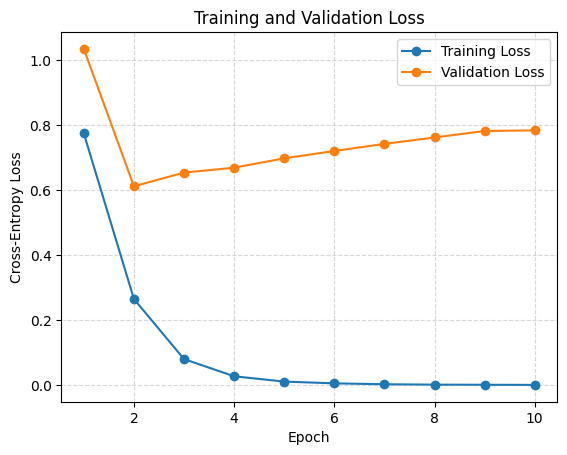

In [ ]:
# Loss Curves
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss', marker="o")
plt.plot(range(1, EPOCHS+1), val_losses,   label='Validation Loss', marker="o")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Cross-Entropy Loss')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Validation Report

In [53]:
def loader_preds(model, loader, device):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).long()
            pred = model(xb).argmax(1)
            ys.append(yb.cpu().numpy())
            ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

In [54]:
y_val_true, y_val_pred = loader_preds(model, val_loader, device)
val_acc = accuracy_score(y_val_true, y_val_pred)
print(f"\nValidation Accuracy: {val_acc:.4f}")
print("Validation classification report:")
print(classification_report(y_val_true, y_val_pred, target_names=label_names, digits=4))
print("Validation confusion matrix:\n", confusion_matrix(y_val_true, y_val_pred))


Validation Accuracy: 0.8350
Validation classification report:
              precision    recall  f1-score   support

    negative     0.7229    0.7500    0.7362       160
     neutral     0.4000    0.6139    0.4844       101
    positive     0.9617    0.8836    0.9210       739

    accuracy                         0.8350      1000
   macro avg     0.6949    0.7492    0.7139      1000
weighted avg     0.8668    0.8350    0.8473      1000

Validation confusion matrix:
 [[120  35   5]
 [ 18  62  21]
 [ 28  58 653]]


### Test Report

In [55]:
y_test_true, y_test_pred = loader_preds(model, test_loader, device)
test_acc = accuracy_score(y_test_true, y_test_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("Test classification report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_names, digits=4))
print("Test confusion matrix:\n", confusion_matrix(y_test_true, y_test_pred))


Test Accuracy: 0.8235
Test classification report:
              precision    recall  f1-score   support

    negative     0.6560    0.7688    0.7079       320
     neutral     0.3643    0.5050    0.4232       202
    positive     0.9658    0.8789    0.9203      1478

    accuracy                         0.8235      2000
   macro avg     0.6620    0.7175    0.6838      2000
weighted avg     0.8555    0.8235    0.8361      2000

Test confusion matrix:
 [[ 246   64   10]
 [  64  102   36]
 [  65  114 1299]]
